<a href="https://colab.research.google.com/github/kkorhone/Python_Notebooks/blob/main/pygex7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pygfunction

     |████████████████████████████████| 81kB 3.6MB/s 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import AutoMinorLocator
from scipy.constants import pi
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve

import pygfunction as gt

In [6]:
def synthetic_load(x):
  
    A = 2000.0
    B = 2190.0
    C = 80.0
    D = 2.0
    E = 0.01
    F = 0.0
    G = 0.95

    func = (168.0 - C) / 168.0

    for i in [1,2,3]:
        func += 1.0 / (i * pi) * (np.cos(C * pi * i / 84.0) - 1.0) * (np.sin(pi * i / 84.0 * (x - B)))

    func = func * A * np.sin(pi / 12.0 * (x - B)) * np.sin(pi / 4380.0 * (x - B))

    y = func + (-1.0)**np.floor(D / 8760.0 * (x - B)) * abs(func) + E * (-1.0)**np.floor(D / 8760.0 * (x - B)) / np.sign(np.cos(D * pi / 4380.0 * (x - F)) + G)

    return -np.array([y])

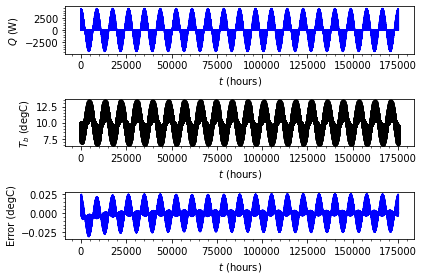

In [7]:
if __name__ == '__main__':

    # -------------------------------------------------------------------------
    # Simulation parameters
    # -------------------------------------------------------------------------

    # Borehole dimensions

    D = 4.0             # Borehole buried depth (m)
    H = 150.0           # Borehole length (m)
    r_b = 0.075         # Borehole radius (m)

    # Ground properties

    alpha = 1.0e-6      # Ground thermal diffusivity (m2/s)
    k_s = 2.0           # Ground thermal conductivity (W/m.K)
    T_g = 10.0          # Undisturbed ground temperature (degC)

    # Number of segments per borehole

    nSegments = 12

    # Simulation parameters

    dt = 3600.                  # Time step (s)
    tmax = 20. * 8760. * 3600.  # Maximum time (s)
    Nt = int(np.ceil(tmax/dt))  # Number of time steps

    # Load aggregation scheme

    LoadAgg = gt.load_aggregation.ClaessonJaved(dt, tmax)

    # -------------------------------------------------------------------------
    # Calculate g-function
    # -------------------------------------------------------------------------

    # The field contains only one borehole

    boreField = [gt.boreholes.Borehole(H, D, r_b, x=0., y=0.)]
    
    # Get time values needed for g-function evaluation
    
    time_req = LoadAgg.get_times_for_simulation()
    
    # Calculate g-function
    
    gFunc = gt.gfunction.uniform_temperature(boreField, time_req, alpha, nSegments=nSegments)
    
    # Initialize load aggregation scheme
    
    LoadAgg.initialize(gFunc/(2*pi*k_s))

    # -------------------------------------------------------------------------
    # Simulation
    # -------------------------------------------------------------------------

    time = 0.
    i = -1
    T_b = np.zeros(Nt)
    Q = np.zeros(Nt)

    while time < tmax:

        # Increment time step by (1)

        time += dt
        i += 1
        LoadAgg.next_time_step(time)

        # Evaluate heat extraction rate

        Q[i] = synthetic_load(time/3600.)

        # Apply current load

        LoadAgg.set_current_load(Q[i]/H)

        # Evaluate borehole wall temeprature

        deltaT_b = LoadAgg.temporal_superposition()
        T_b[i] = T_g - deltaT_b

    # -------------------------------------------------------------------------
    # Calculate exact solution from convolution in the Fourier domain
    # -------------------------------------------------------------------------

    # Heat extraction rate increment
    dQ = np.zeros(Nt)
    dQ[0] = Q[0]
    # Interpolated g-function
    time = np.array([(j+1)*dt for j in range(Nt)])
    g = interp1d(time_req, gFunc)(time)
    for i in range(1, Nt):
        dQ[i] = Q[i] - Q[i-1]

    # Convolution in Fourier domain
    T_b_exact = T_g - fftconvolve(dQ, g/(2.0*pi*k_s*H), mode='full')[0:Nt]

    # -------------------------------------------------------------------------
    # plot results
    # -------------------------------------------------------------------------

    plt.rc('figure')
    fig = plt.figure()

    ax1 = fig.add_subplot(311)
    # Axis labels
    ax1.set_xlabel(r'$t$ (hours)')
    ax1.set_ylabel(r'$Q$ (W)')
    hours = np.array([(j+1)*dt/3600. for j in range(Nt)])
    ax1.plot(hours, Q, 'b-', lw=1.5)

    ax2 = fig.add_subplot(312)
    # Axis labels
    ax2.set_xlabel(r'$t$ (hours)')
    ax2.set_ylabel(r'$T_b$ (degC)')
    ax2.plot(hours, T_b, 'b-', lw=1.5)
    ax2.plot(hours, T_b_exact, 'k.', lw=1.5)

    ax3 = fig.add_subplot(313)
    # Axis labels
    ax3.set_xlabel(r'$t$ (hours)')
    ax3.set_ylabel(r'Error (degC)')
    ax3.plot(hours, T_b - T_b_exact, 'b-', lw=1.5)
    # Show minor ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.xaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax3.xaxis.set_minor_locator(AutoMinorLocator())
    ax3.yaxis.set_minor_locator(AutoMinorLocator())
    # Adjust to plot window
    plt.tight_layout()